In [ ]:
##An example from the other Becky

(5994,) (50, 5994)
--------------------------------------------------
Template library output path: .
Template library output file: mileshc.fits
Found 49 MILESHC templates
Maximum number of wavelength channels: 4300
Attempting to build raw data ...


/Users/beckynevin/Work/MaNGA/dap/2.1.3/python/mangadap/proc/templatelibrary.py:1520: UserWarning: Overwriting existing file: mileshc.fits
  warnings.warn('Overwriting existing file: {0}'.format(self.processed_file))


... done
Matching sampling ... 


/Users/beckynevin/Work/MaNGA/dap/2.1.3/python/mangadap/proc/templatelibrary.py:1197: UserWarning: Resampling has cause resolution below the two pixel limit!
  warnings.warn('Resampling has cause resolution below the two pixel limit!')


... done
After resampling (target): 0.0001
After resampling (calculated): 9.999999999999987e-05
Writing: ./mileshc.fits
--------------------------------------------------


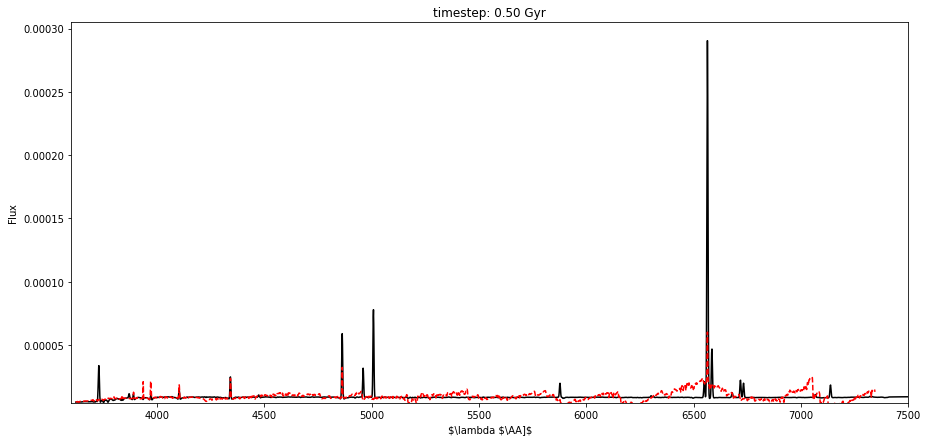

Number of templates: 49
Number of object spectra: 50
Pixel scale: 69.02976447828435 km/s
Pixel scale ratio: 1
Dispersion limits: 0.6902976447828435 - 1000.0
Kinematics fixed: False
Model degrees of freedom: 60
Iteration mode: none
Additive polynomial order: 8
Multiplicative polynomial order: None
Number of object spectra to fit: 50/50
Running pPXF fit on spectrum: 50/50
pPXF finished


In [90]:
import numpy as np

from mangadap.proc.templatelibrary import TemplateLibrary

from mangadap.proc.ppxffit import PPXFFit
from mangadap.proc.stellarcontinuummodel import StellarContinuumModelBitMask
from mangadap.proc.emissionlinemodel import EmissionLineModelBitMask

from matplotlib import pyplot as plt 
from scipy import interpolate
from astropy import constants as con
from astropy import units as un

from matplotlib.animation import FuncAnimation

import math

c = con.c.to(un.km/un.s).value
time_steps = np.linspace(0.5, 14, 50)

# Here I load up some example spectra so you can see an example working.
# These are spectra created with Charlie Conroy's Flexible Stellar 
# Population Synthesis (FSPS) code at 50 different observed time steps 
# defined above, each with the same exponential declining SFHs described by 
# [tq, tau] ~ [10, 1.0] Gyr. Shape of array is (50, 5994). They've already 
# been smoothed to the minimum detectable velocity dispersion of MaNGA ~ 77 km/s.  
fsps_spec = np.load('conroy_fsps_example_spectra_tq_10.0_tau_1.0_Gyr.npy')
# Load up the (5994,) wavelength array from the conroy FSPS models
fsps_wave = np.load('conroy_fsps_wavelengths.npy')

#Load the MaNGA wavelengths array shape (4563, )
manga_wave = np.load('manga_wavelengths_AA.npy')

# Interpolate the model FSPS spectra to be on the MaNGA wavelength array
print(fsps_wave.shape, fsps_spec.shape)
int_func = interpolate.interp1d(fsps_wave, fsps_spec)
fsps_flux = int_func(manga_wave)



# Set up the MILES models that the DAP PPXF module needs to run
tpl = TemplateLibrary('MILESHC',
                        match_to_drp_resolution=False,
                        velscale_ratio=1,  # this would be 0 if your fake spectra didn't have the same velocity scale as MaNGA  
                        spectral_step=1e-4,
                        log=True,
                        directory_path='.',
                        processed_file='mileshc.fits',
                        clobber=True)

plt.plot(tpl['WAVE'].data, tpl['FLUX'].data[0])
plt.title('Templates')
plt.show()

# Instantiate the python PPXF object that actually does the fitting
contbm = EmissionLineModelBitMask()#StellarContinuumModelBitMask()
ppxf = PPXFFit(contbm)

# Provide a guess redshift and guess velocity dispersion for PPXF.
# My fake spectra aren't redshifted so I give it the smallest redshift
# that doesn't throw an error - this was found through trial and error!
# The dispersion I know because I already smoothed the spectra to have 
# the same dispersion as the minimum detectable by MaNGA (see above). 
nspec = fsps_flux.shape[0]
guess_redshift = np.full(nspec, 0.0003, dtype=float)
guess_dispersion = np.full(nspec, 77.0, dtype=float) 

# Then we do the actual PPXF fit...
model_wave, model_flux, model_mask, model_par  = ppxf.fit(tpl_wave=tpl['WAVE'].data.copy(), tpl_flux=tpl['FLUX'].data.copy(), obj_wave=manga_wave, obj_flux=fsps_flux, obj_ferr=np.ones_like(fsps_flux), guess_redshift=guess_redshift, guess_dispersion=guess_dispersion, iteration_mode='none', velscale_ratio=1, degree=8, mdegree=-1, moments=2, quiet=False)
#


# The model_mask tells you which parts of the spectra it didn't fit that well
# so make sure you take a look at that, but for the plotting below I've just 
# included the whole fit, regardless of the mask. If you look at the plots 
# you can see how around Halpha the fit goes a bit haywire.  


# Then let's plot the spectra at each time step and see if the continuum was 
# actually fitted properly - this is in gif form but if you don't have 
# imagemagick I'm not sure this will work. There's also a simple plot 
# at each time step for loop below as well, if you prefer. Just uncomment. 

def update(n):
    label = r'timestep: '+str("{0:.2f}".format(time_steps[n]))+' Gyr'
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(fsps_flux[n])
    line2.set_ydata(model_flux[n])
    ax.set_title(label, color='k')
    ax.set_ylim(0.95*np.nanmin(fsps_flux[n][:idx]), 1.05*np.nanmax(fsps_flux[n][:idx]))
    return line, ax

fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.set_xlim(3600, 7500)
idx = fsps_wave.searchsorted(7500)
#qidx = time_steps.searchsorted(tq)
line, = ax.plot(manga_wave, fsps_flux[0], color='k')
line2, = ax.plot(model_wave, model_flux[0], color='r', linestyle='dashed')
ax.set_xlabel(r'$\lambda $\AA]$')
ax.set_ylabel(r'$\rm{Flux}$')

anim = FuncAnimation(fig, update, frames=np.arange(0, nspec), interval=200)
anim.save('example_ppxf_fit_conroy_fsps.gif', dpi=80, writer='imagemagick')


# Instead we can plot the spectra at each time step in a for loop 
# to see if the continuum was fitted properly
# for n in range(nspec):
# 	plt.figure(figsize=(15,7))
# 	plt.plot(manga_wave, fsps_flux[n], color='k')
# 	plt.plot(model_wave, model_flux[n], color='r', linestyle='dashed')
# 	plt.xlabel(r'$\lambda [\AA]$')
# 	plt.ylabel(r'$\rm{Flux}$')
# 	plt.xlim(3600, 7500)
# 	plt.tight_layout()
# 	plt.savefig('example_ppxf_fit_conroy_fsps_time_step_'+str("{0:.2f}".format(time_steps[n]))+'_Gyr.png')
# 	plt.close()


In [ ]:
##Now, attempting to modify for my own purposes

In [ ]:
import numpy as np

from mangadap.proc.templatelibrary import TemplateLibrary

from mangadap.proc.ppxffit import PPXFFit
from mangadap.proc.stellarcontinuummodel import StellarContinuumModelBitMask
from mangadap.proc.emissionlinemodel import EmissionLineModelBitMask

from matplotlib import pyplot as plt 
from scipy import interpolate
from astropy import constants as con
from astropy import units as un

from matplotlib.animation import FuncAnimation

import pyfits
from astropy.cosmology import WMAP9 as cosmo

c = con.c.to(un.km/un.s).value


# Here I load up some example spectra so you can see an example working.
# These are spectra created with Charlie Conroy's Flexible Stellar 
# Population Synthesis (FSPS) code at 50 different observed time steps 
# defined above, each with the same exponential declining SFHs described by 
# [tq, tau] ~ [10, 1.0] Gyr. Shape of array is (50, 5994). They've already 
# been smoothed to the minimum detectable velocity dispersion of MaNGA ~ 77 km/s.  
fsps_spec = np.load('conroy_fsps_example_spectra_tq_10.0_tau_1.0_Gyr.npy')
# Load up the (5994,) wavelength array from the conroy FSPS models
fsps_wave = np.load('conroy_fsps_wavelengths.npy')

#Load the MaNGA wavelengths array shape (4563, )
manga_wave = np.load('manga_wavelengths_AA.npy')

print('manga_wave', manga_wave, manga_wave[1]-manga_wave[0])
print('fsps_wave', fsps_wave, fsps_wave[1]-fsps_wave[0])

#Load in the mcrx file, which has many extensions, we are just concerned with the 25 one, which is scattered camera0
mcrx=pyfits.open('../../LAURA_Sims/q0.5_fg0.3_allrx10_sunruns/hirestest_kin/mcrx_230.fits')
CAMERA0=mcrx[18]
Ang=np.array([x[0]*10**(10) for x in mcrx[5].data])
print('mcrx_wave',Ang)

pixelscale=CAMERA0.header['CD1_1']

kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)
out=CAMERA0.data[:,152:205,174:227]
#out=CAMERA0.data[:,170:175, 200:205]

input_all = np.reshape(out, (out.shape[0],out.shape[1]*out.shape[2]))
input_all = input_all.T
#input_all = np.sum(out, axis=(1,2))
#make input_all into a vector 
#input_all=out.flatten()

time_steps = np.linspace(0.5, 14, out.shape[1]*out.shape[2])

print((input_all.shape))

#actually need to cut MaNGA spectra so you can then interpolate onto it
min_index=np.where(manga_wave==find_nearest(manga_wave,Ang[0]))[0][0]+1
max_index=np.where(manga_wave==find_nearest(manga_wave,Ang[-1]))[0][0]-1

cut_manga_wave=manga_wave[min_index:max_index]
print('cut_manga_wave', cut_manga_wave)


print(Ang.shape, input_all.shape)
int_func = interpolate.interp1d(Ang, input_all)
int_flux = int_func(cut_manga_wave)




#spec_resample, spec_errs_resample = spectres(Ang, np.array(input_all), cut_manga_wave, spec_errs=np.array(input_all/73)\
#)








# Interpolate the model FSPS spectra to be on the MaNGA wavelength array
#int_func = interpolate.interp1d(fsps_wave, fsps_spec)
#fsps_flux = int_func(manga_wave)

# Set up the MILES models that the DAP PPXF module needs to run
tpl = TemplateLibrary('MILESHC',
                        match_to_drp_resolution=False,
                        velscale_ratio=1,  #1: this would be 0 if your fake spectra didn't have the same velocity scale as MaNGA  
                        spectral_step=1e-4,
                        log=True,
                        directory_path='.',
                        processed_file='mileshc.fits',
                        clobber=True)



# Instantiate the python PPXF object that actually does the fitting
contbm = EmissionLineModelBitMask()#StellarContinuumModelBitMask()
ppxf = PPXFFit(contbm)

# Provide a guess redshift and guess velocity dispersion for PPXF.
# My fake spectra aren't redshifted so I give it the smallest redshift
# that doesn't throw an error - this was found through trial and error!
# The dispersion I know because I already smoothed the spectra to have 
# the same dispersion as the minimum detectable by MaNGA (see above). 


nspec = int_flux.shape[0]
guess_redshift = np.full(nspec, 0.0003, dtype=float)
guess_dispersion = np.full(nspec, 77.0, dtype=float) 

print('shape of obj_flux',int_flux.shape, cut_manga_wave.shape)



# Then we do the actual PPXF fit...
model_wave, model_flux, model_mask, model_par  = ppxf.fit(tpl_wave=tpl['WAVE'].data.copy(), tpl_flux=tpl['FLUX'].data.copy(), obj_wave=cut_manga_wave, obj_flux=int_flux, obj_ferr=np.ones_like(int_flux), guess_redshift=guess_redshift, guess_dispersion=guess_dispersion, iteration_mode='none', velscale_ratio=1, degree=8, mdegree=-1, moments=2, quiet=False)



# The model_mask tells you which parts of the spectra it didn't fit that well
# so make sure you take a look at that, but for the plotting below I've just 
# included the whole fit, regardless of the mask. If you look at the plots 
# you can see how around Halpha the fit goes a bit haywire.  


# Then let's plot the spectra at each time step and see if the continuum was 
# actually fitted properly - this is in gif form but if you don't have 
# imagemagick I'm not sure this will work. There's also a simple plot 
# at each time step for loop below as well, if you prefer. Just uncomment. 




def update(n):
    label = r'timestep: '+str("{0:.2f}".format(time_steps[n]))+' Gyr'
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(int_flux[n])
    line2.set_ydata(model_flux[n])
    
    ax.set_title(label, color='k')
    ax.set_ylim(0.95*np.nanmin(input_all[n][:idx]), 1.05*np.nanmax(input_all[n][:idx]))
    return line, ax

fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
ax.set_xlim(3600, 7500)
idx = fsps_wave.searchsorted(7500)
#qidx = time_steps.searchsorted(tq)
line, = ax.plot(cut_manga_wave, int_flux[0], color='k')
line2, = ax.plot(model_wave, model_flux[0], color='r', linestyle='dashed')
ax.set_xlabel(r'$\lambda $\AA]$')
ax.set_ylabel(r'$\rm{Flux}$')

anim = FuncAnimation(fig, update, frames=np.arange(0, nspec), interval=200)
anim.save('example_ppxf_fit_mcrx.gif', dpi=80, writer='imagemagick')


# Instead we can plot the spectra at each time step in a for loop 
# to see if the continuum was fitted properly
# for n in range(nspec):
# 	plt.figure(figsize=(15,7))
# 	plt.plot(manga_wave, fsps_flux[n], color='k')
# 	plt.plot(model_wave, model_flux[n], color='r', linestyle='dashed')
# 	plt.xlabel(r'$\lambda [\AA]$')
# 	plt.ylabel(r'$\rm{Flux}$')
# 	plt.xlim(3600, 7500)
# 	plt.tight_layout()
# 	plt.savefig('example_ppxf_fit_conroy_fsps_time_step_'+str("{0:.2f}".format(time_steps[n]))+'_Gyr.png')
# 	plt.close()


manga_wave [  3621.59598486   3622.42998417   3623.26417553 ...,  10349.03843826
  10351.42166679  10353.80544415] 0.833999306794
fsps_wave [  9.10000000e+01   9.40000000e+01   9.60000000e+01 ...,   9.81700000e+07
   9.90800000e+07   1.00000000e+08] 3.0


/Users/beckynevin/anaconda/lib/python3.6/site-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (10327588864) is smaller than the expected size (12750629760)
  (self.size, pos))


mcrx_wave [ 3300.00681161  3300.21686604  3300.42715668 ...,  6988.86086339
  6989.30610157  6989.75139647]
(2809, 11781)
cut_manga_wave [ 3622.42998417  3623.26417553  3624.098559   ...,  6983.93196541
  6985.54026033  6987.14892561]
(11781,) (2809, 11781)
--------------------------------------------------
Template library output path: .
Template library output file: mileshc.fits
Found 49 MILESHC templates
Maximum number of wavelength channels: 4300
Attempting to build raw data ...


/Users/beckynevin/Work/MaNGA/dap/2.1.3/python/mangadap/proc/templatelibrary.py:1520: UserWarning: Overwriting existing file: mileshc.fits
  warnings.warn('Overwriting existing file: {0}'.format(self.processed_file))


... done
Matching sampling ... 


/Users/beckynevin/Work/MaNGA/dap/2.1.3/python/mangadap/proc/templatelibrary.py:1197: UserWarning: Resampling has cause resolution below the two pixel limit!
  warnings.warn('Resampling has cause resolution below the two pixel limit!')


... done
After resampling (target): 0.0001
After resampling (calculated): 9.999999999999987e-05
Writing: ./mileshc.fits
--------------------------------------------------
shape of obj_flux (2809, 2854) (2854,)
Number of templates: 49
Number of object spectra: 2809
Pixel scale: 69.02976447828426 km/s
Pixel scale ratio: 1
Dispersion limits: 0.6902976447828426 - 1000.0
Kinematics fixed: False
Model degrees of freedom: 60
Iteration mode: none
Additive polynomial order: 8
Multiplicative polynomial order: None
Number of object spectra to fit: 2809/2809


In [97]:
print(model_par[0])
print(model_par[0][12])
print(model_par[0][13])
print(model_par[0][14])

(0, 0, 0, 0, 2854, 2854, 2854, array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00762609,  0.        ,  0.        ,  0.04724712,  0.        ,
        0.03551349,  0.        ,  0.00783312,  0.0087007 ,  0.        ,
        0.        ,  0.        ,  0.01592249,  0.        ,  0.        ,
        0.00718004,  0.02274152,  0.17354341,  0.28712757,  0.0273171 ,
        0.        ,  0.        ,  0.        ,  0.0297009 ,  0.        ,
        0.        ,  0.04282679,  0.01323606,  0.04519173,  0.        ,
        0.00040309,  0.02197179,  0.00492544,  0.        ]), array([ 0.65358857,  1.2817754 ,  0.64209807,  2.54642414,  1.47502223,
        1.8625779 ,  1.08561422,  1.30063489,  2.24997408,  1.82692511,
        2.7426154 ,  0.88536784,  0.75343512,  1.4438747 ,  0.94572273,
        0.35585904,  0.50992313,  0.74256197

In [19]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def make_bins(wavelengths, make_rhs="False"):
    bin_widths = np.zeros(wavelengths.shape[0])

    # This option makes the final entry in the left hand sides array the right hand side of the final bin                 
    if make_rhs == "True":
        bin_lhs = np.zeros(wavelengths.shape[0]+1)
        #The first lhs position is assumed to be as far from the first central wavelength as the rhs of the first bin.    
        bin_lhs[0] = wavelengths[0] - (wavelengths[1]-wavelengths[0])/2
        bin_widths[-1] = (wavelengths[-1] - wavelengths[-2])
        bin_lhs[-1] = wavelengths[-1] + (wavelengths[-1]-wavelengths[-2])/2
        bin_lhs[1:-1] = (wavelengths[1:] + wavelengths[:-1])/2
        bin_widths[:-1] = bin_lhs[1:-1]-bin_lhs[:-2]

    # Otherwise just return the lhs positions of each bin                                                                 
    else:
        bin_lhs = np.zeros(wavelengths.shape[0])
        bin_lhs[0] = wavelengths[0] - (wavelengths[1]-wavelengths[0])/2
        bin_widths[-1] = (wavelengths[-1] - wavelengths[-2])
        bin_lhs[1:] = (wavelengths[1:] + wavelengths[:-1])/2
        bin_widths[:-1] = bin_lhs[1:]-bin_lhs[:-1]

    return bin_lhs, bin_widths
def spectres(spec_wavs, spec_fluxes, resampling, spec_errs=None):

    # Generate arrays of left hand side positions and widths for the old and new bins                                     
    filter_lhs, filter_widths = make_bins(resampling, make_rhs="True")
    spec_lhs, spec_widths = make_bins(spec_wavs)


    # Check that the range of wavelengths to be resampled onto falls within the initial sampling region                   
    if filter_lhs[0] < spec_lhs[0] or filter_lhs[-1] > spec_lhs[-1]:
        print("Spec_lhs, filter_lhs, filter_rhs, spec_rhs ", spec_lhs[0], filter_lhs[0], filter_lhs[-1], spec_lhs[-1])
        sys.exit("spectres was passed a spectrum which did not cover the full wavelength range of the specified filter cu\
rve.")


    #Generate output arrays to be populated                                                                               
    if spec_fluxes.ndim == 1:
        resampled = np.zeros((resampling.shape[0]))

    elif spec_fluxes.ndim == 2:
        resampled = np.zeros((len(resampling), spec_fluxes.shape[1]))

    if spec_errs is not None:
        if spec_errs.shape != spec_fluxes.shape:
            sys.exit("If specified, spec_errs must be the same shape as spec_fluxes.")
        else:
            resampled_errs = np.copy(resampled)

    start = 0
    stop = 0

    # Calculate the new spectral flux and uncertainty values, loop over the new bins                                      
    for j in range(len(filter_lhs)-1):

        # Find the first old bin which is partially covered by the new bin                                                
        while spec_lhs[start+1] <= filter_lhs[j]:
            start += 1

        # Find the last old bin which is partially covered by the new bin                                                 
        while spec_lhs[stop+1] < filter_lhs[j+1]:
            stop += 1

        if spec_fluxes.ndim == 1:

            # If the new bin falls entirely within one old bin the are the same the new flux and new error are the same as for that bin                                                                                                            
            if stop == start:

                resampled[j] = spec_fluxes[start]
                if spec_errs is not None:
                    resampled_errs[j] = spec_errs[start]
            # Otherwise multiply the first and last old bin widths by P_ij, all the ones in between have P_ij = 1         
            else:

                start_factor = (spec_lhs[start+1] - filter_lhs[j])/(spec_lhs[start+1] - spec_lhs[start])
                end_factor = (filter_lhs[j+1] - spec_lhs[stop])/(spec_lhs[stop+1] - spec_lhs[stop])

                spec_widths[start] *= start_factor
                spec_widths[stop] *= end_factor

                # Populate the resampled spectrum and uncertainty arrays                                                  
                resampled[j] = np.sum(spec_widths[start:stop+1]*spec_fluxes[start:stop+1])/np.sum(spec_widths[start:stop+\
1])

                if spec_errs is not None:
                    resampled_errs[j] = np.sqrt(np.sum((spec_widths[start:stop+1]*spec_errs[start:stop+1])**2))/np.sum(sp\
ec_widths[start:stop+1])

                # Put back the old bin widths to their initial values for later use                                       
                spec_widths[start] /= start_factor
                spec_widths[stop] /= end_factor

        elif spec_fluxes.ndim == 2:

            if stop == start:

                resampled[j, :] = spec_fluxes[start, :]
                if spec_errs is not None:
                    resampled_errs[j, :] = spec_errs[start, :]

            else:

                start_factor = (spec_lhs[start+1] - filter_lhs[j])/(spec_lhs[start+1] - spec_lhs[start])
                end_factor = (filter_lhs[j+1] - spec_lhs[stop])/(spec_lhs[stop+1] - spec_lhs[stop])

                spec_widths[start] *= start_factor
                spec_widths[stop] *= end_factor

                resampled[j, :] = np.sum(np.expand_dims(spec_widths[start:stop+1], axis=1)*spec_fluxes[start:stop+1, :], \
axis=0)/np.sum(spec_widths[start:stop+1])

                if spec_errs is not None:
                    resampled_errs[j, :] = np.sqrt(np.sum((np.expand_dims(spec_widths[start:stop+1], axis=1)*spec_errs[st\
art:stop+1])**2, axis=0))/np.sum(spec_widths[start:stop+1])

                spec_widths[start] /= start_factor
                spec_widths[stop] /= end_factor


    # If errors were supplied return the resampled spectrum and error arrays                                              
    if spec_errs is not None:
        return resampled, resampled_errs

    # Otherwise just return the resampled spectrum array                                                                  
    else:
        return resampled
def convolve_spatially(input_data,factor, plot):
    if ((len(input_data[0,:,0])/factor).is_integer()):
        length=int(len(input_data[0,:,0])/factor)
    else:
        stop


    data_new = np.zeros((len(input_data[:,0,0]), length, length))

    data_new += input_data[:, ::factor, ::factor] + input_data[:, 1::factor, ::factor] + input_data[:, ::factor, 1::facto\
r] + input_data[:, 1\
::factor, 1::factor]# Take (0,0)                                                                                         \
                                                                                                                          


    if plot=='yes':
        plt.clf()
        plt.imshow(np.sum(input_data, axis=0),norm=LogNorm(vmin=0.001, vmax=10**5))
        plt.colorbar()
        plt.savefig('Figs/before_26.pdf')
        plt.clf()
        plt.imshow(np.sum(data_new, axis=0),norm=LogNorm(vmin=0.001, vmax=10**5))
        plt.colorbar()
        plt.savefig('Figs/after_26.pdf')

    return data_new
def extract_spec_one(input_spec, xpoint, ypoint):


    new_cube = input_spec[:,xpoint,ypoint]



    integrated=new_cube

    regrid=[]
    next_lambda=Ang[3]
    step = 6563/(2000*2.355)
    max_index=int((Ang[-1]-Ang[3])/step)
    for i in range(max_index):
        regrid.append(Ang[3]+step*i)

    regrid=np.array(regrid)

    spec_resample, spec_errs_resample = spectres(np.array(Ang), np.array(integrated), regrid, spec_errs=np.array(integrat\
ed/73))




    spec_resample_norm=spec_resample/np.median(spec_resample)



    return Ang, integrated, regrid, spec_resample_norm# was z                                                             

def arc_to_pix(arc):
    return (arc*(kpc_arcmin.value/60))/pixelscale
